In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from bing_helper import load_json_files, get_hits_from_json, load_lang_news_hits
from regression import fit_regression_and_rename_coeffs_by_cat, fit_regression_and_rename_coeffs, write_reg_results
from processing import filter_by_region_cat_code, build_regression_dataframe, load_preprocessed_events
from plot_regression import plot_regression_results, plot_regression_results_interactions, plot_country_counts, plot_regression_results_interactions_from_dict, plot_cat_by_cat_variable
from preprocessing import load_if_in_country_or_lang
from steinkasserer.preprocessing import categorize_views_for_df

%load_ext autoreload
%autoreload 2

/home/ruptho/.local/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## load Data


In [2]:
df_crawled = load_preprocessed_events()
df_crawled = load_if_in_country_or_lang(df_crawled)
data = build_regression_dataframe(df_crawled)
df_crawled.head()

/home/ruptho/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ruptho/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,population,Country/Area,Year,GDP_pc,GDP,oecd,date_month,views_baseline,in_code_lang,in_code_region
0,Q100021,Pakistan International Airlines Flight 661,2016-12-07,Global South,Pakistan,Asia,disaster,"['Category:2016 disasters in Pakistan', 'Categ...",248274,0.000000,...,203631356,Pakistan,2016,1362.860008,2.775210e+11,False,2016-12-01,8.684000e+07,True,False
1,Q100231328,Gretchen Whitmer kidnapping plot,2020-10-08,Global North,United States,North America,disaster,"['Category:2020 crimes in the United States', ...",74144,0.000000,...,329484123,United States,2020,63122.594145,2.089375e+13,True,2020-10-01,3.137752e+09,True,True
2,Q100256872,Killing of Babu Lal Vaishnav,2020-10-08,Global South,India,Asia,disaster,"['Category:2020 crimes in India', 'Category:20...",427,0.000000,...,1380004385,India,2020,1930.971218,2.664749e+12,False,2020-10-01,7.142770e+08,True,False
3,Q100279235,Miss Vietnam 2020,2020-11-20,Global South,Vietnam,Asia,culture,"['Category:2020 beauty pageants', 'Category:Be...",1444,49.285714,...,97338583,Vietnam,2020,2785.724225,2.711584e+11,False,2020-11-01,1.619000e+07,False,False
4,Q100288161,2020 Ganja missile attacks,2020-10-11,Global South,Azerbaijan,Asia,disaster,"['Category:2020 in Azerbaijan', 'Category:Arti...",7410,0.000000,...,10093121,Azerbaijan,2020,4202.232239,4.260718e+10,False,2020-10-01,3.088000e+06,False,False


In [3]:
df_crawled = categorize_views_for_df(df_crawled)

In [4]:
df_crawled.head()

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Country/Area,Year,GDP_pc,GDP,oecd,date_month,views_baseline,in_code_lang,in_code_region,views_baseline_cat
0,Q100021,Pakistan International Airlines Flight 661,2016-12-07,Global South,Pakistan,Asia,disaster,"['Category:2016 disasters in Pakistan', 'Categ...",248274,0.000000,...,Pakistan,2016,1362.860008,2.775210e+11,False,2016-12-01,8.684000e+07,True,False,>10^7
1,Q100231328,Gretchen Whitmer kidnapping plot,2020-10-08,Global North,United States,North America,disaster,"['Category:2020 crimes in the United States', ...",74144,0.000000,...,United States,2020,63122.594145,2.089375e+13,True,2020-10-01,3.137752e+09,True,True,>10^9
2,Q100256872,Killing of Babu Lal Vaishnav,2020-10-08,Global South,India,Asia,disaster,"['Category:2020 crimes in India', 'Category:20...",427,0.000000,...,India,2020,1930.971218,2.664749e+12,False,2020-10-01,7.142770e+08,True,False,>10^8
3,Q100279235,Miss Vietnam 2020,2020-11-20,Global South,Vietnam,Asia,culture,"['Category:2020 beauty pageants', 'Category:Be...",1444,49.285714,...,Vietnam,2020,2785.724225,2.711584e+11,False,2020-11-01,1.619000e+07,False,False,>10^7
4,Q100288161,2020 Ganja missile attacks,2020-10-11,Global South,Azerbaijan,Asia,disaster,"['Category:2020 in Azerbaijan', 'Category:Arti...",7410,0.000000,...,Azerbaijan,2020,4202.232239,4.260718e+10,False,2020-10-01,3.088000e+06,False,False,>10^6


# Poisson regression, Quasi-regression model, Non-negative binomial model
https://www.youtube.com/watch?v=jnKDQtDy0Bg

https://www.youtube.com/watch?v=uGKnoAw-PFQ

In [5]:
from processing import compute_mean_and_variance
import statsmodels.api as sm
from plot_regression import plot_pearson_residuals

In [6]:
# excluding all articles that have no category or less than 10 recorded views in the week after the event happened
df_filtered = df_crawled[(df_crawled.cat != 'undefined') & (df_crawled.views_7_sum > 10)]
data_filtered = build_regression_dataframe(df_filtered)

/home/ruptho/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ruptho/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='mean', ylabel='var'>

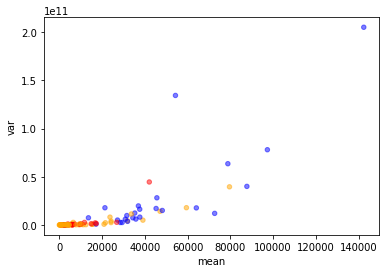

In [7]:
# mean-variance plot suggests to use negative binomial model! this is supported by poisson regression below (deviance >>>> DoF, very small error bars)
mean_var = compute_mean_and_variance(df_filtered, ['code', 'gni_region', 'cat'])['views_7_sum']
col_map = {'de': 'orange', 'en': 'blue', 'es': 'red', 'it': 'orange'}
col = [col_map[var[0]] for var in mean_var.index]
mean_var.plot.scatter(x='mean', y='var', color=col, alpha=0.5)

In [8]:
compute_mean_and_variance(df_filtered, ['code', 'gni_region', 'cat'])['views_7_sum']

mean           var
code gni_region            cat                                 
de   East Asia & Pacific   culture     266.333333  3.605733e+04
                           disaster  15254.400000  5.976131e+08
                           politics   5466.906250  3.057974e+07
                           sports     2646.382514  5.694921e+07
     Europe & Central Asia culture   11182.569620  1.937942e+08
...                                           ...           ...
it   South Asia            politics     69.500000  6.844500e+03
                           sports     1137.000000  1.630818e+06
     Sub-Saharan Africa    disaster   2054.666667  1.383099e+07
                           politics    292.928571  1.095870e+05
                           sports    10393.000000  5.819687e+08

[103 rows x 2 columns]

In [9]:
compute_mean_and_variance(df_filtered, 'gni_class')

views_7_sum              
                   mean           var
gni_class                            
H          25927.824198  2.182053e+10
L          26345.761194  4.042424e+09
LM         27390.089691  7.568149e+09
UM         23020.099937  1.482262e+10

### Poisson Regression

In [10]:
df_code = df_filtered[df_filtered.code == 'en']

In [11]:
model_ps = sm.GLM.from_formula('views_7_sum ~ cat * gni_class', family=sm.families.Poisson(), data=df_code).fit()
model_ps.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Generalized linear model
==================================================================================
Model:                    GLM                  AIC:                1080169578.9799
Link Function:            Log                  BIC:                1080023249.6438
Dependent Variable:       views_7_sum          Log-Likelihood:     -5.4008e+08    
Date:                     2022-03-08 08:38     LL-Null:            -5.6871e+08    
No. Observations:         7606                 Deviance:           1.0801e+09     
Df Model:                 15                   Pearson chi2:       5.62e+09       
Df Residuals:             7590                 Scale:              1.0000         
Method:                   IRLS                                                    
----------------------------------------------------------------------------------
                                 Coef.  Std.Err.     z      P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------
Intercept                       10.8004   0.0002 55268.8111 0.0000 10.8000 10.8008
cat[T.disaster]                  0.8605   0.0002  3494.3627 0.0000  0.8601  0.8610
cat[T.politics]                 -0.0793   0.0002  -346.0216 0.0000 -0.0797 -0.0788
cat[T.sports]                   -0.5643   0.0002 -2509.2747 0.0000 -0.5648 -0.5639
gni_class[T.L]                  -5.5927   0.0427  -130.9206 0.0000 -5.6764 -5.5090
gni_class[T.LM]                 -1.2597   0.0011 -1142.1850 0.0000 -1.2619 -1.2575
gni_class[T.UM]                 -0.6622   0.0009  -727.2578 0.0000 -0.6639 -0.6604
cat[T.disaster]:gni_class[T.L]   4.8507   0.0427   113.5442 0.0000  4.7670  4.9345
cat[T.politics]:gni_class[T.L]   5.1794   0.0427   121.2210 0.0000  5.0956  5.2631
cat[T.sports]:gni_class[T.L]     5.2208   0.0428   121.9968 0.0000  5.1369  5.3047
cat[T.disaster]:gni_class[T.LM]  0.5310   0.0012   458.0111 0.0000  0.5287  0.5332
cat[T.politics]:gni_class[T.LM]  1.0222   0.0012   872.8715 0.0000  1.0199  1.0245
cat[T.sports]:gni_class[T.LM]    1.4242   0.0012  1213.6062 0.0000  1.4219  1.4265
cat[T.disaster]:gni_class[T.UM]  0.0746   0.0010    76.7500 0.0000  0.0727  0.0765
cat[T.politics]:gni_class[T.UM]  0.2651   0.0010   269.9097 0.0000  0.2632  0.2671
cat[T.sports]:gni_class[T.UM]    0.9450   0.0009  1013.8470 0.0000  0.9432  0.9468
==================================================================================

"""

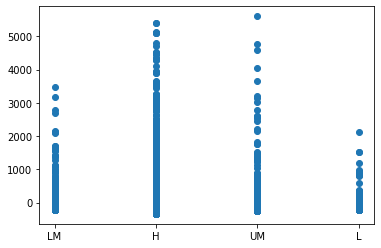

In [12]:
resid_outliers = model_ps.resid_pearson.nlargest(15)
outlier_filter = ~model_ps.resid_pearson.isin(resid_outliers)
plt.scatter(df_code.loc[outlier_filter, :].gni_class, model_ps.resid_pearson[outlier_filter])

In [13]:
# compute dispersion: ssqpearsonres / degrees of freedom

In [14]:
sum(np.square(model_ps.resid_pearson)) / model_ps.df_model

374400581.5530272

## Negative Binomial

In [15]:
model_neg_f = sm.GLM.from_formula('views_7_sum ~ cat * gni_region * code', family=sm.families.NegativeBinomial(),
                                  data=df_filtered)
model_neg = model_neg_f.fit()
model_neg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                14801
Model:                            GLM   Df Residuals:                    14698
Model Family:        NegativeBinomial   Df Model:                          102
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5734e+05
Date:                Tue, 08 Mar 2022   Deviance:                       57811.
Time:                        08:38:49   Pearson chi2:                 3.50e+05
No. Iterations:                   100   Pseudo R-squ. (CS):             0.6410
Covariance Type:            nonrobust                                         
=======================================================================================================================================
                                                                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                               5.5847      0.578      9.655      0.000       4.451       6.718
cat[T.disaster]                                                         4.0479      0.633      6.390      0.000       2.806       5.289
cat[T.politics]                                                         3.0217      0.605      4.996      0.000       1.836       4.207
cat[T.sports]                                                           2.2962      0.583      3.938      0.000       1.153       3.439
gni_region[T.Europe & Central Asia]                                     3.7374      0.589      6.342      0.000       2.582       4.892
gni_region[T.Latin America & Caribbean]                                -0.0630      0.248     -0.254      0.799      -0.548       0.422
gni_region[T.Middle East & North Africa]                                0.0064      1.157      0.005      0.996      -2.261       2.274
gni_region[T.North America]                                             5.1757      0.606      8.545      0.000       3.989       6.363
gni_region[T.South Asia]                                               -0.3950      0.184     -2.141      0.032      -0.756      -0.033
gni_region[T.Sub-Saharan Africa]                                       -0.8349      0.422     -1.978      0.048      -1.662      -0.008
code[T.en]                                                              3.9340      0.585      6.725      0.000       2.787       5.081
code[T.es]                                                              1.0033      0.818      1.227      0.220      -0.599       2.606
code[T.it]                                                             -1.8875      0.822     -2.296      0.022      -3.499      -0.276
cat[T.disaster]:gni_region[T.Europe & Central Asia]                    -3.0023      0.650     -4.617      0.000      -4.277      -1.728
cat[T.politics]:gni_region[T.Europe & Central Asia]                    -1.7697      0.619     -2.859      0.004      -2.983      -0.556
cat[T.sports]:gni_region[T.Europe & Central Asia]                      -2.9348      0.595     -4.933      0.000      -4.101      -1.769
cat[T.disaster]:gni_region[T.Latin America & Caribbean]                 0.4085      0.365      1.120      0.263      -0.307       1.124
cat[T.politics]:gni_region[T.Latin America & Caribbean]                -0.1474      0.317     -0.464      0.642      -0.770       0.475
cat[T.sports]:gni_region[T.Latin America & Caribbean]                   0.9661      0.263      3.679      0.000       0.451       1.481
cat[T.disaster]:gni_region[T.Middle East & North Africa]                0.3091      1.201  

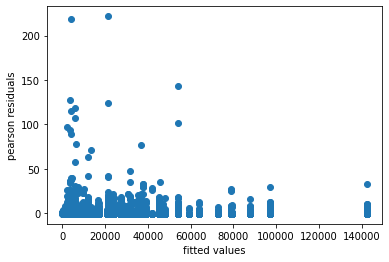

In [16]:
plot_pearson_residuals(df_filtered, model_neg, 0, None)

In [17]:
model_neg.fittedvalues

0         64097.621202
1        142457.853242
2         64097.621202
3         13612.887115
4         97346.746817
             ...      
14913     37620.766062
14914     27227.301598
14915     27227.301598
14916      4303.655272
14917      5874.475426
Length: 14801, dtype: float64

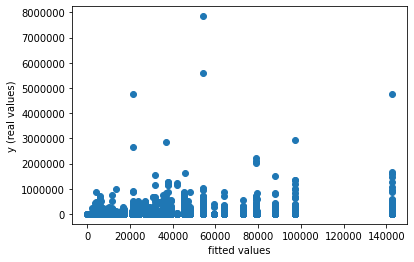

In [18]:
from steinkasserer.plot_regression import plot_real_vs_fitted

plot_real_vs_fitted(df_filtered, model_neg, log_scale=False)

In [19]:
df_filtered['fitted'] = model_neg.fittedvalues

/tmp/ipykernel_3013/2546756375.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['fitted'] = model_neg.fittedvalues


In [20]:
df_filtered[(df_filtered.views_7_sum > (model_neg.fittedvalues * 20)) & (df_filtered.views_7_sum > 2*10**6)]

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Year,GDP_pc,GDP,oecd,date_month,views_baseline,in_code_lang,in_code_region,views_baseline_cat,fitted
229,Q170645,2018 FIFA World Cup,2018-06-14,Global North,Russia,Europe,sports,"['Category:2017–18 in Russian football', 'Cate...",4756233,188749.000000,...,2018,11372.277988,1.657328e+12,False,2018-06-01,6.418600e+07,False,False,>10^7,21338.125992
384,Q189571,UEFA Euro 2016,2016-06-10,Global North,France,Europe,sports,"['Category:2015–16 in French football', 'Categ...",2663535,118587.428571,...,2016,36979.702257,2.471286e+12,True,2016-06-01,9.501500e+07,False,False,>10^7,21338.125992
466,Q20022969,88th Academy Awards,2016-02-28,Global North,United States,North America,culture,"['Category:2015 film awards', 'Category:2016 a...",2095840,53235.857143,...,2016,57876.719077,1.869511e+13,True,2016-02-01,3.429789e+09,True,True,>10^9,78854.422721
736,Q21479779,November 2015 Paris attacks,2015-11-13,Global North,France,Europe,disaster,"['Category:10th arrondissement of Paris', 'Cat...",2931843,0.000000,...,2015,36611.753912,2.438208e+12,True,2015-11-01,9.531800e+07,False,False,>10^7,97346.746817
945,Q22076019,89th Academy Awards,2017-02-26,Global North,United States,North America,culture,"['Category:2016 film awards', 'Category:2017 a...",2013088,49717.000000,...,2017,59921.674703,1.947962e+13,True,2017-02-01,3.313535e+09,True,True,>10^9,78854.422721
1117,Q22923830,2020 United States presidential election,2020-11-03,Global North,United States,North America,politics,['Category:2020 United States presidential ele...,7847440,186775.857143,...,2020,63122.594145,2.089375e+13,True,2020-11-01,3.137752e+09,True,True,>10^9,54331.563062
4408,Q47496499,92nd Academy Awards,2020-02-09,Global North,United States,North America,culture,"['Category:2019 film awards', 'Category:2020 a...",2226447,53921.428571,...,2020,63122.594145,2.089375e+13,True,2020-02-01,3.297605e+09,True,True,>10^9,78854.422721
6833,Q699872,2016 United States presidential election,2016-11-08,Global North,United States,North America,politics,['Category:2016 United States presidential ele...,5580333,108.714286,...,2016,57876.719077,1.869511e+13,True,2016-11-01,3.132468e+09,True,True,>10^9,54331.563062
7369,Q8613,2016 Summer Olympics,2016-08-05,Global South,Brazil,South America,sports,"['Category:2010s in Rio de Janeiro', 'Category...",2866833,112068.571429,...,2016,8710.063417,1.795693e+12,False,2016-08-01,6.046900e+07,False,False,>10^7,36988.382921
7426,Q95579249,Murder of George Floyd,2020-05-25,Global North,United States,North America,disaster,"['Category:2020 controversies', 'Category:2020...",4748626,0.000000,...,2020,63122.594145,2.089375e+13,True,2020-05-01,3.455160e+09,True,True,>10^9,142457.853242


In [21]:
df_filtered.fitted.max()

142457.85324154526

In [22]:
df_filtered[df_filtered.fitted > (12 * 10**4)]

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Year,GDP_pc,GDP,oecd,date_month,views_baseline,in_code_lang,in_code_region,views_baseline_cat,fitted
1,Q100231328,Gretchen Whitmer kidnapping plot,2020-10-08,Global North,United States,North America,disaster,"['Category:2020 crimes in the United States', ...",74144,0.0,...,2020,63122.594145,2.089375e+13,True,2020-10-01,3.137752e+09,True,True,>10^9,142457.853242
14,Q100804527,October 2020 Alaska Peninsula earthquake,2020-10-19,Global North,United States,North America,disaster,['Category:Redirects from merges'],2230,0.0,...,2020,63122.594145,2.089375e+13,True,2020-10-01,3.137752e+09,True,True,>10^9,142457.853242
39,Q101072249,Quebec City stabbing,2020-10-31,Global North,Canada,North America,disaster,"['Category:2020 in Quebec', 'Category:2020 mur...",6635,0.0,...,2020,43559.710092,1.644037e+12,True,2020-10-01,3.592780e+08,True,False,>10^8,142457.853242
70,Q104215553,Kenosha unrest shooting,2020-08-25,Global North,United States,North America,disaster,['Category:2020 controversies in the United St...,33248,0.0,...,2020,63122.594145,2.089375e+13,True,2020-08-01,3.455160e+09,True,True,>10^9,142457.853242
76,Q104511862,2020 Nashville bombing,2020-12-25,Global North,United States,North America,disaster,"['Category:2020 crimes in the United States', ...",568610,0.0,...,2020,63122.594145,2.089375e+13,True,2020-12-01,3.166022e+09,True,True,>10^9,142457.853242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7482,Q96396444,Northern Arizona University shooting,2015-10-09,Global North,United States,North America,disaster,"['Category:2015 in Arizona', 'Category:2015 ma...",38,0.0,...,2015,56738.091771,1.820602e+13,True,2015-10-01,3.431834e+09,True,True,>10^9,142457.853242
7520,Q97357872,Reactions to the murder of George Floyd,2020-05-25,Global North,United States,North America,disaster,['Category:Aftermath of the George Floyd prote...,11,0.0,...,2020,63122.594145,2.089375e+13,True,2020-05-01,3.455160e+09,True,True,>10^9,142457.853242
7579,Q98605503,Shooting of Jacob Blake,2020-08-23,Global North,United States,North America,disaster,['Category:2020 controversies in the United St...,1285795,0.0,...,2020,63122.594145,2.089375e+13,True,2020-08-01,3.455160e+09,True,True,>10^9,142457.853242
7589,Q98800012,Shooting of Cannon Hinnant,2020-08-09,Global North,United States,North America,disaster,"['Category:2020 in North Carolina', 'Category:...",7076,0.0,...,2020,63122.594145,2.089375e+13,True,2020-08-01,3.455160e+09,True,True,>10^9,142457.853242


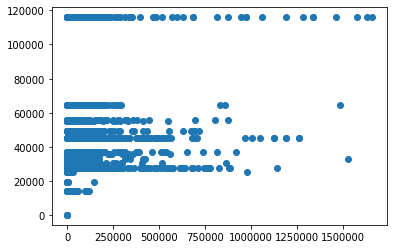

In [24]:
resid_outliers = model_ps.resid_pearson.nlargest(10)
outlier_filter = ~model_ps.resid_pearson.isin(resid_outliers)
fig, ax = plt.subplots()
ax.scatter(df_code.loc[outlier_filter, :].views_7_sum, model_ps.fittedvalues[outlier_filter])
ax.ticklabel_format(style='plain')

<AxesSubplot:ylabel='Frequency'>

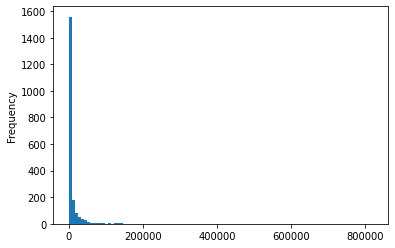

In [25]:
df_filtered[df_filtered.code == 'de'].views_7_sum.plot.hist(bins=100)

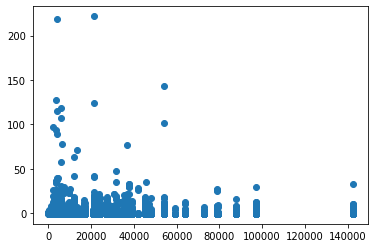

In [26]:
plt.scatter(model_neg.fittedvalues, model_neg.resid_pearson)

# Visualization

In [27]:
df_filtered.groupby(['code', 'cat', 'gni_class']).size()

code  cat       gni_class
de    culture   H             109
                LM              1
                UM              4
      disaster  H             120
                L              23
                             ... 
it    politics  UM             44
      sports    H            1093
                L               2
                LM             19
                UM            400
Length: 61, dtype: int64

In [28]:
df_filtered.nlargest(10, 'views_7_sum')

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Year,GDP_pc,GDP,oecd,date_month,views_baseline,in_code_lang,in_code_region,views_baseline_cat,fitted
1117,Q22923830,2020 United States presidential election,2020-11-03,Global North,United States,North America,politics,['Category:2020 United States presidential ele...,7847440,186775.857143,...,2020,63122.594145,2.089375e+13,True,2020-11-01,3.137752e+09,True,True,>10^9,54331.563062
6833,Q699872,2016 United States presidential election,2016-11-08,Global North,United States,North America,politics,['Category:2016 United States presidential ele...,5580333,108.714286,...,2016,57876.719077,1.869511e+13,True,2016-11-01,3.132468e+09,True,True,>10^9,54331.563062
229,Q170645,2018 FIFA World Cup,2018-06-14,Global North,Russia,Europe,sports,"['Category:2017–18 in Russian football', 'Cate...",4756233,188749.000000,...,2018,11372.277988,1.657328e+12,False,2018-06-01,6.418600e+07,False,False,>10^7,21338.125992
7426,Q95579249,Murder of George Floyd,2020-05-25,Global North,United States,North America,disaster,"['Category:2020 controversies', 'Category:2020...",4748626,0.000000,...,2020,63122.594145,2.089375e+13,True,2020-05-01,3.455160e+09,True,True,>10^9,142457.853242
736,Q21479779,November 2015 Paris attacks,2015-11-13,Global North,France,Europe,disaster,"['Category:10th arrondissement of Paris', 'Cat...",2931843,0.000000,...,2015,36611.753912,2.438208e+12,True,2015-11-01,9.531800e+07,False,False,>10^7,97346.746817
7369,Q8613,2016 Summer Olympics,2016-08-05,Global South,Brazil,South America,sports,"['Category:2010s in Rio de Janeiro', 'Category...",2866833,112068.571429,...,2016,8710.063417,1.795693e+12,False,2016-08-01,6.046900e+07,False,False,>10^7,36988.382921
384,Q189571,UEFA Euro 2016,2016-06-10,Global North,France,Europe,sports,"['Category:2015–16 in French football', 'Categ...",2663535,118587.428571,...,2016,36979.702257,2.471286e+12,True,2016-06-01,9.501500e+07,False,False,>10^7,21338.125992
4408,Q47496499,92nd Academy Awards,2020-02-09,Global North,United States,North America,culture,"['Category:2019 film awards', 'Category:2020 a...",2226447,53921.428571,...,2020,63122.594145,2.089375e+13,True,2020-02-01,3.297605e+09,True,True,>10^9,78854.422721
466,Q20022969,88th Academy Awards,2016-02-28,Global North,United States,North America,culture,"['Category:2015 film awards', 'Category:2016 a...",2095840,53235.857143,...,2016,57876.719077,1.869511e+13,True,2016-02-01,3.429789e+09,True,True,>10^9,78854.422721
945,Q22076019,89th Academy Awards,2017-02-26,Global North,United States,North America,culture,"['Category:2016 film awards', 'Category:2017 a...",2013088,49717.000000,...,2017,59921.674703,1.947962e+13,True,2017-02-01,3.313535e+09,True,True,>10^9,78854.422721


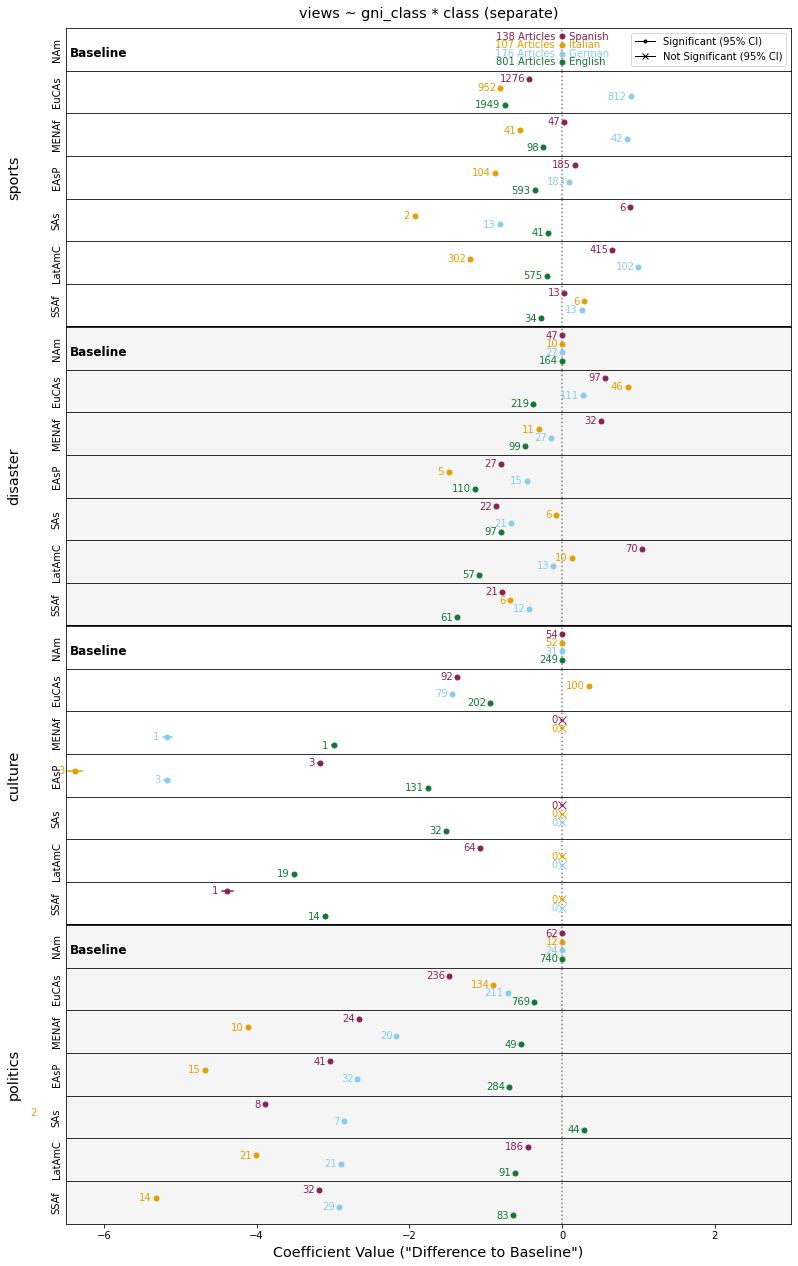

In [29]:
from regression import fit_regression_and_rename_coeffs_by_cat

results_fit_separate = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                               formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_region, Treatment(reference='North America'))",
                                                               type='poisson')

fig_int_region_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                       results_fit_separate, ['cat:gni_region'],
                                                                       {'gni_class': 'H', 'in_code_lang': True,
                                                                        'gni_region': 'North America', 'cat': 'sports',
                                                                        'code': 'en'},
                                                                       label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                   'cat': ['sports', 'disaster',
                                                                                           'culture', 'politics'],
                                                                                   'gni_region': ['North America',
                                                                                                  'Europe & Central Asia',
                                                                                                  'Middle East & North Africa',
                                                                                                  'East Asia & Pacific',
                                                                                                  'South Asia',
                                                                                                  'Latin America & Caribbean',
                                                                                                  'Sub-Saharan Africa']},
                                                                       cat_dict={'en': 'English', 'it': 'Italian',
                                                                                 'es': 'Spanish', 'de': 'German'},
                                                                       title='views ~ gni_class * class (separate)',
                                                                       label_rename_dict={
                                                                           'Middle East & North Africa': 'MENAf',
                                                                           'Latin America & Caribbean': 'LatAmC',
                                                                           'Europe & Central Asia': 'EuCAs',
                                                                           'East Asia & Pacific': 'EAsP',
                                                                           'North America': 'NAm',
                                                                           'Sub-Saharan Africa': 'SSAf',
                                                                           'South Asia': 'SAs'},
                                                                       figsize=(13, 22), x_limits=(-6.5, 3),
                                                                       include_counts=True)

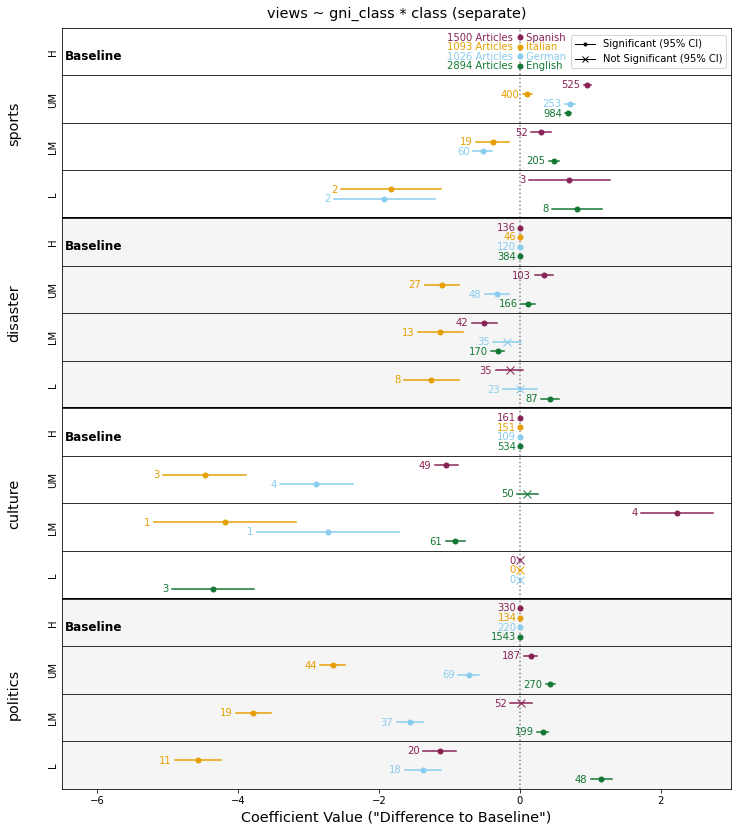

In [30]:
from regression import fit_regression_and_rename_coeffs_by_cat

results_fit_separate_class_control = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                                             formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_class, Treatment(reference='H')) + np.log1p(views_baseline)",
                                                                             type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_class_control,
                                                                      ['cat:gni_class'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='views ~ gni_class * class (separate)',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 14), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_class_control.pdf')

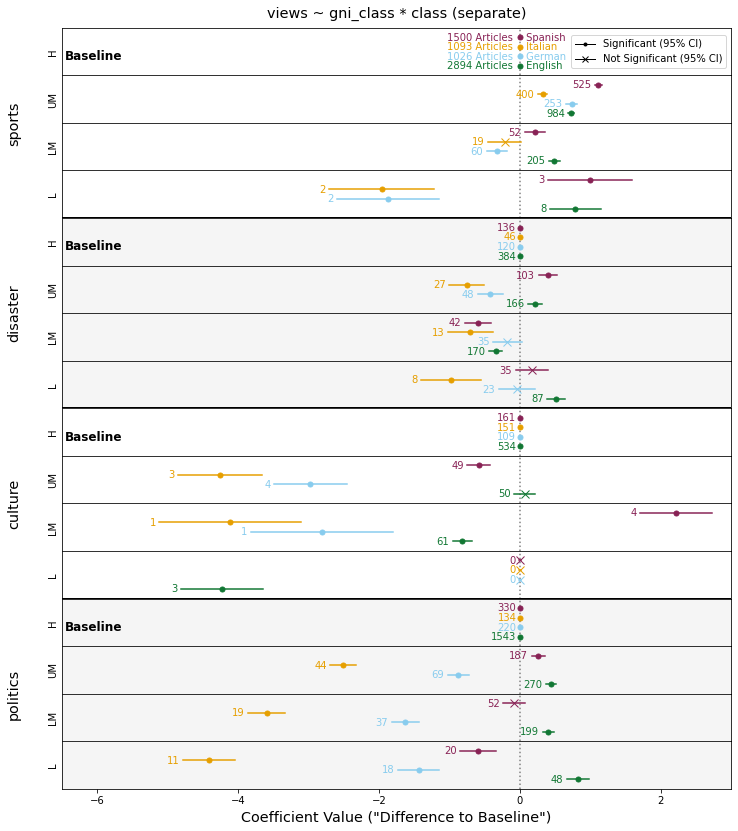

In [31]:
from regression import fit_regression_and_rename_coeffs_by_cat

results_fit_separate_class_controlcat = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                                             formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_class, Treatment(reference='H')) + C(views_baseline_cat, Treatment(reference='>10^8'))",
                                                                             type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_class_controlcat,
                                                                      ['cat:gni_class'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='views ~ gni_class * class (separate)',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 14), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_class_controlcat.pdf')

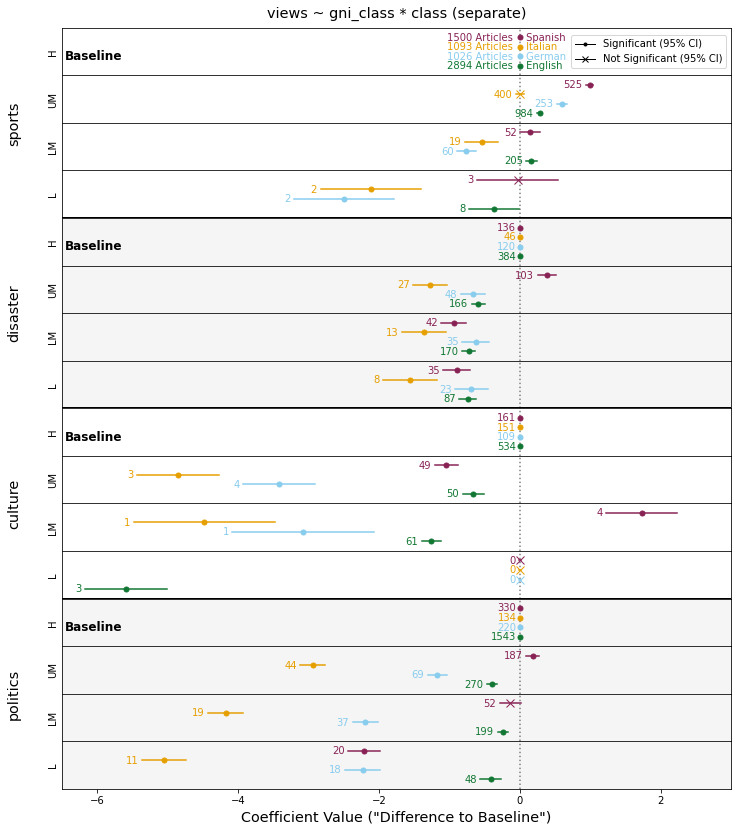

In [32]:
results_fit_separate_class = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                                     formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_class, Treatment(reference='H'))",
                                                                     type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_class, ['cat:gni_class'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='views ~ gni_class * class (separate)',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 14), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_class.pdf')

In [33]:
results_fit_separate_class['en'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                 7606
Model:                            GLM   Df Residuals:                     7590
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -87698.
Date:                Tue, 08 Mar 2022   Deviance:                       31200.
Time:                        08:39:06   Pearson chi2:                 1.38e+05
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1487
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          10.2361      0.019    550.648      0.000      10.200      10.272
cat[T.culture]                      0.5643      0.047     11.982      0.000       0.472       0.657
cat[T.disaster]                     1.4249      0.054     26.235      0.000       1.318       1.531
cat[T.politics]                     0.4850      0.032     15.387      0.000       0.423       0.547
gni_class[T.L]                     -0.3719      0.354     -1.050      0.294      -1.066       0.322
gni_class[T.LM]                     0.1645      0.072      2.276      0.023       0.023       0.306
gni_class[T.UM]                     0.2829      0.037      7.665      0.000       0.211       0.355
cat[T.culture]:gni_class[T.L]      -5.2208      0.680     -7.678      0.000      -6.554      -3.888
cat[T.disaster]:gni_class[T.L]     -0.3701      0.373     -0.991      0.322      -1.102       0.362
cat[T.politics]:gni_class[T.L]     -0.0414      0.383     -0.108      0.914      -0.792       0.710
cat[T.culture]:gni_class[T.LM]     -1.4242      0.153     -9.292      0.000      -1.725      -1.124
cat[T.disaster]:gni_class[T.LM]    -0.8932      0.117     -7.628      0.000      -1.123      -0.664
cat[T.politics]:gni_class[T.LM]    -0.4020      0.104     -3.851      0.000      -0.607      -0.197
cat[T.culture]:gni_class[T.UM]     -0.9450      0.152     -6.200      0.000      -1.244      -0.646
cat[T.disaster]:gni_class[T.UM]    -0.8704      0.100     -8.708      0.000      -1.066      -0.675
cat[T.politics]:gni_class[T.UM]    -0.6799      0.076     -8.994      0.000      -0.828      -0.532
===================================================================================================
"""

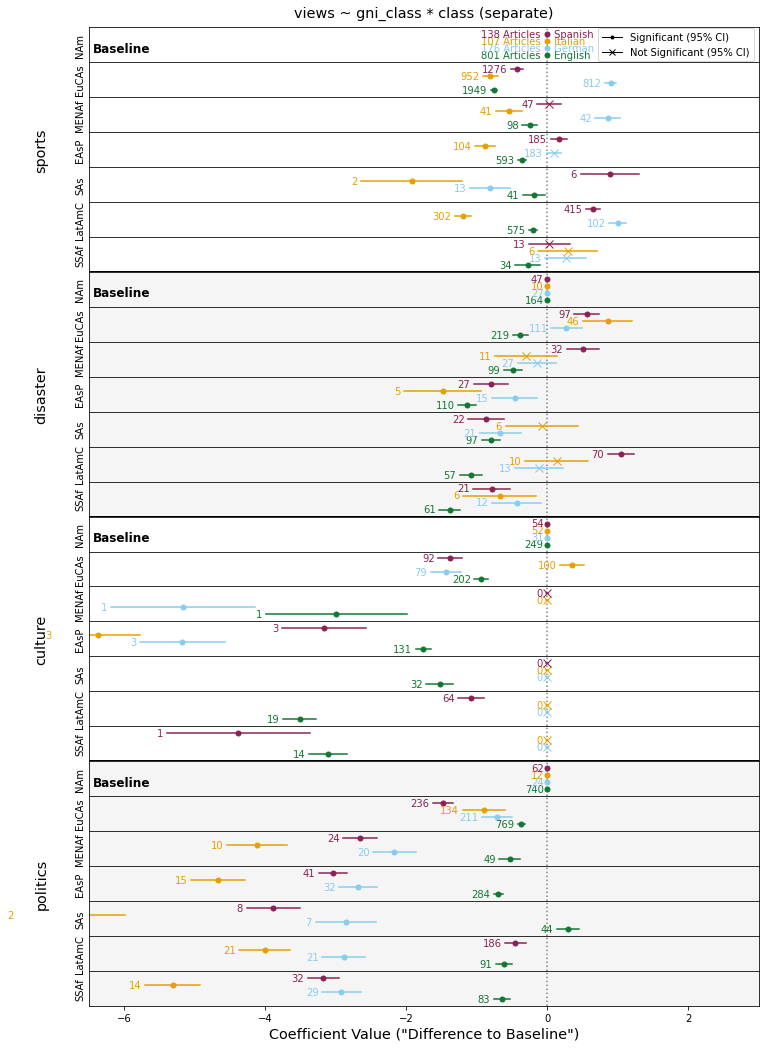

In [34]:
results_fit_separate_region = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                                      formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_region, Treatment(reference='North America'))",
                                                                      type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_region, ['cat:gni_region'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='views ~ gni_class * class (separate)',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 18), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_region.pdf')

In [35]:
df_filtered.views_baseline_cat.value_counts()

>10^7    4087
>10^6    3310
>10^8    2719
>10^5    2012
>10^9    1770
>10^4     650
>10^3     206
>10^2      33
>=0        14
Name: views_baseline_cat, dtype: int64

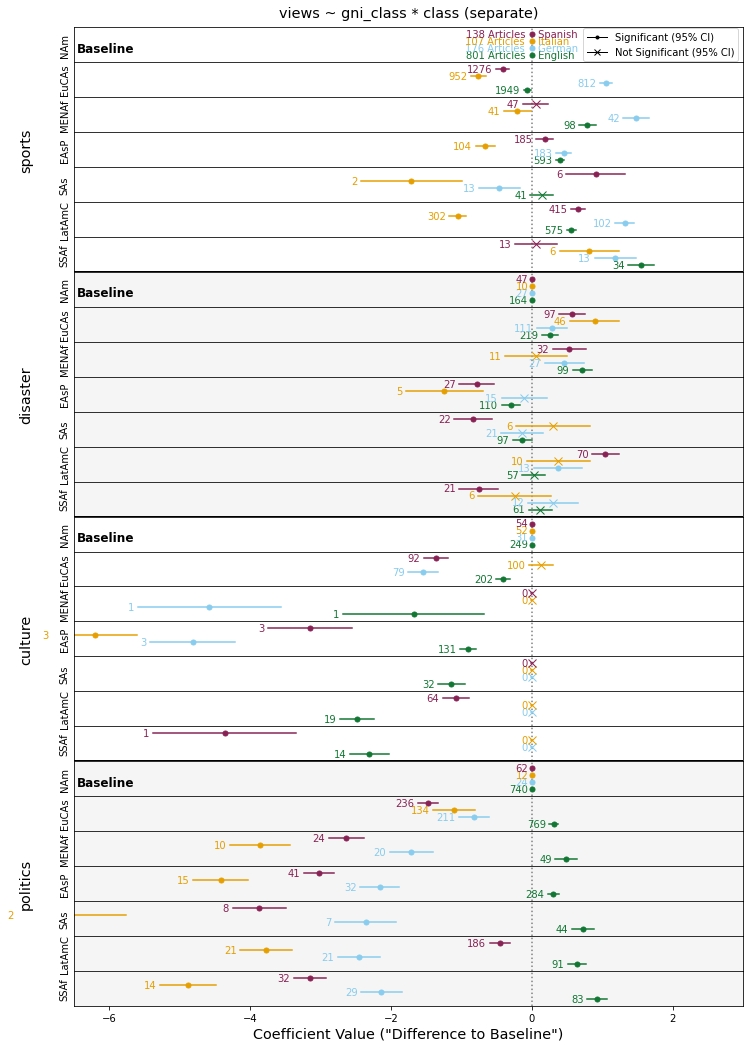

In [36]:
results_fit_separate_region = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                                      formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_region, Treatment(reference='North America')) + np.log1p(views_baseline)",
                                                                      type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_region, ['cat:gni_region'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='views ~ gni_class * class (separate)',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 18), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_region_control.pdf')

In [37]:
results_fit_separate_class['en'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                 7606
Model:                            GLM   Df Residuals:                     7590
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -87698.
Date:                Tue, 08 Mar 2022   Deviance:                       31200.
Time:                        08:39:17   Pearson chi2:                 1.38e+05
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1487
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          10.2361      0.019    550.648      0.000      10.200      10.272
cat[T.culture]                      0.5643      0.047     11.982      0.000       0.472       0.657
cat[T.disaster]                     1.4249      0.054     26.235      0.000       1.318       1.531
cat[T.politics]                     0.4850      0.032     15.387      0.000       0.423       0.547
gni_class[T.L]                     -0.3719      0.354     -1.050      0.294      -1.066       0.322
gni_class[T.LM]                     0.1645      0.072      2.276      0.023       0.023       0.306
gni_class[T.UM]                     0.2829      0.037      7.665      0.000       0.211       0.355
cat[T.culture]:gni_class[T.L]      -5.2208      0.680     -7.678      0.000      -6.554      -3.888
cat[T.disaster]:gni_class[T.L]     -0.3701      0.373     -0.991      0.322      -1.102       0.362
cat[T.politics]:gni_class[T.L]     -0.0414      0.383     -0.108      0.914      -0.792       0.710
cat[T.culture]:gni_class[T.LM]     -1.4242      0.153     -9.292      0.000      -1.725      -1.124
cat[T.disaster]:gni_class[T.LM]    -0.8932      0.117     -7.628      0.000      -1.123      -0.664
cat[T.politics]:gni_class[T.LM]    -0.4020      0.104     -3.851      0.000      -0.607      -0.197
cat[T.culture]:gni_class[T.UM]     -0.9450      0.152     -6.200      0.000      -1.244      -0.646
cat[T.disaster]:gni_class[T.UM]    -0.8704      0.100     -8.708      0.000      -1.066      -0.675
cat[T.politics]:gni_class[T.UM]    -0.6799      0.076     -8.994      0.000      -0.828      -0.532
===================================================================================================
"""

In [38]:
df_filtered.views_baseline_cat.value_counts()>10^9

>10^7    True
>10^6    True
>10^8    True
>10^5    True
>10^9    True
>10^4    True
>10^3    True
>10^2    True
>=0      True
Name: views_baseline_cat, dtype: bool

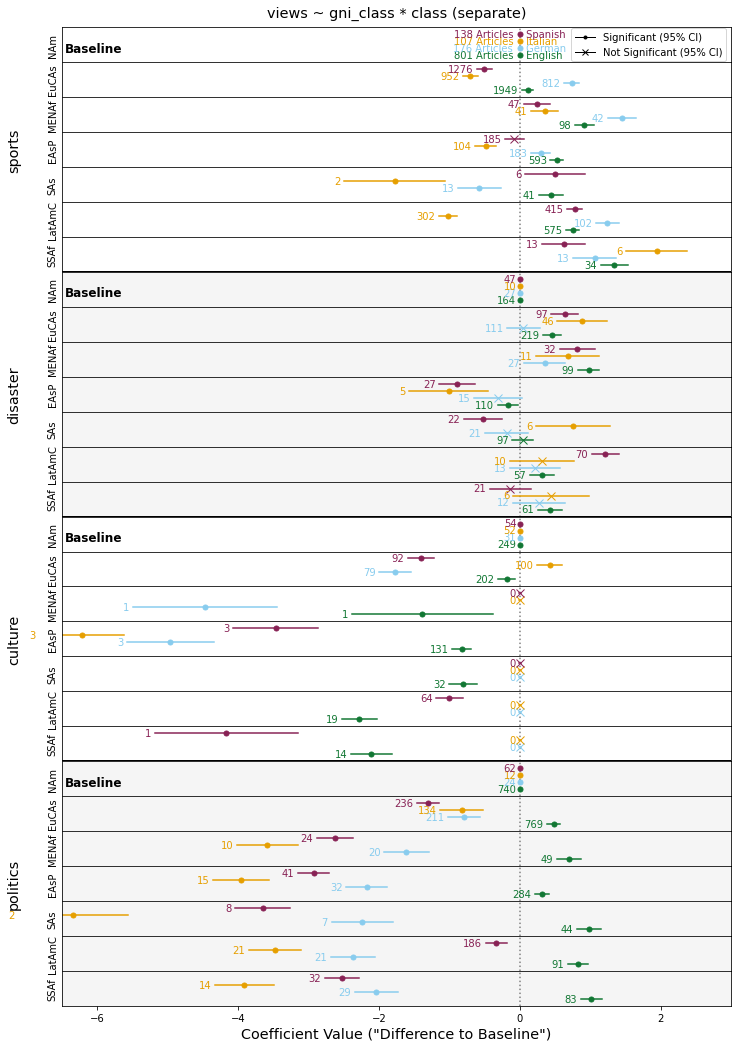

In [39]:
results_fit_separate_region_controlcat = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                                      formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_region, Treatment(reference='North America')) + C(views_baseline_cat, Treatment(reference='>10^8'))",
                                                                      type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_region_controlcat, ['cat:gni_region'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='views ~ gni_class * class (separate)',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 18), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_region_controlcat.pdf')

In [40]:
results_fit_separate_region['de'].summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                    Results: Generalized linear model
=========================================================================================================
Model:                            GLM                            AIC:                          40281.3397
Link Function:                    Log                            BIC:                          -7755.2452
Dependent Variable:               views_7_sum                    Log-Likelihood:               -20115.   
Date:                             2022-03-08 08:39               LL-Null:                      -21141.   
No. Observations:                 2025                           Deviance:                     7463.8    
Df Model:                         25                             Pearson chi2:                 4.41e+04  
Df Residuals:                     1999                           Scale:                        1.0000    
Method:                           IRLS                                                                   
---------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                                 5.9984   0.1797  33.3868 0.0000  5.6463  6.3505
cat[T.culture]                                            2.9333   0.1948  15.0585 0.0000  2.5515  3.3151
cat[T.disaster]                                           2.3042   0.2067  11.1474 0.0000  1.8990  2.7093
cat[T.politics]                                           3.5301   0.2176  16.2223 0.0000  3.1036  3.9566
gni_region[T.East Asia & Pacific]                         0.4540   0.1083   4.1927 0.0000  0.2418  0.6663
gni_region[T.Europe & Central Asia]                       1.0517   0.0838  12.5519 0.0000  0.8874  1.2159
gni_region[T.Latin America & Caribbean]                   1.3178   0.1299  10.1448 0.0000  1.0632  1.5724
gni_region[T.Middle East & North Africa]                  1.4785   0.1785   8.2845 0.0000  1.1287  1.8282
gni_region[T.South Asia]                                 -0.4625   0.2895  -1.5978 0.1101 -1.0298  0.1048
gni_region[T.Sub-Saharan Africa]                          1.1845   0.2942   4.0264 0.0001  0.6079  1.7611
cat[T.culture]:gni_region[T.East Asia & Pacific]         -5.2660   0.6148  -8.5650 0.0000 -6.4711 -4.0610
cat[T.disaster]:gni_region[T.East Asia & Pacific]        -0.5585   0.3392  -1.6464 0.0997 -1.2234  0.1064
cat[T.politics]:gni_region[T.East Asia & Pacific]        -2.6111   0.2914  -8.9617 0.0000 -3.1822 -2.0401
cat[T.culture]:gni_region[T.Europe & Central Asia]       -2.5940   0.2280 -11.3796 0.0000 -3.0408 -2.1472
cat[T.disaster]:gni_region[T.Europe & Central Asia]      -0.7654   0.2302  -3.3255 0.0009 -1.2166 -0.3143
cat[T.politics]:gni_region[T.Europe & Central Asia]      -1.8724   0.2309  -8.1086 0.0000 -2.3250 -1.4198
cat[T.culture]:gni_region[T.Latin America & Caribbean]    0.0000   0.0000   4.7770 0.0000  0.0000  0.0000
cat[T.disaster]:gni_region[T.Latin America & Caribbean]  -0.9505   0.3599  -2.6406 0.0083 -1.6559 -0.2450
cat[T.politics]:gni_region[T.Latin America & Caribbean]  -3.7703   0.3240 -11.6350 0.0000 -4.4054 -3.1351
cat[T.culture]:gni_region[T.Middle East & North Africa]  -6.0512   1.0322  -5.8622 0.0000 -8.0743 -4.0280
cat[T.disaster]:gni_region[T.Middle East & North Africa] -1.0182   0.3219  -3.1637 0.0016 -1.6491 -0.3874
cat[T.politics]:gni_region[T.Middle East & North Africa] -3.1876   0.3481  -9.1572 0.0000 -3.8698 -2.5053
cat[T.culture]:gni_region[T.South Asia]                  -0.0000   0.0000  -1.0156 0.3098 -0.0000  0.0000
cat[T.disaster]:gni_region[T.South Asia]                  0.3231   0.4095   0.7891 0.4301 -0.4795  1.1258
cat[T.politics]:gni_region[T.South Asia]                 -1.8954 

In [41]:
results_fit_separate_region['de']

In [42]:
 results_fit_separate_region['de'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                 2025
Model:                            GLM   Df Residuals:                     1999
Model Family:        NegativeBinomial   Df Model:                           25
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20115.
Date:                Tue, 08 Mar 2022   Deviance:                       7463.8
Time:                        08:39:23   Pearson chi2:                 4.41e+04
No. Iterations:                    14   Pseudo R-squ. (CS):             0.6372
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    5.9984      0.180     33.387      0.000       5.646       6.351
cat[T.culture]                                               2.9333      0.195     15.058      0.000       2.552       3.315
cat[T.disaster]                                              2.3042      0.207     11.147      0.000       1.899       2.709
cat[T.politics]                                              3.5301      0.218     16.222      0.000       3.104       3.957
gni_region[T.East Asia & Pacific]                            0.4540      0.108      4.193      0.000       0.242       0.666
gni_region[T.Europe & Central Asia]                          1.0517      0.084     12.552      0.000       0.887       1.216
gni_region[T.Latin America & Caribbean]                      1.3178      0.130     10.145      0.000       1.063       1.572
gni_region[T.Middle East & North Africa]                     1.4785      0.178      8.285      0.000       1.129       1.828
gni_region[T.South Asia]                                    -0.4625      0.289     -1.598      0.110      -1.030       0.105
gni_region[T.Sub-Saharan Africa]                             1.1845      0.294      4.026      0.000       0.608       1.761
cat[T.culture]:gni_region[T.East Asia & Pacific]            -5.2660      0.615     -8.565      0.000      -6.471      -4.061
cat[T.disaster]:gni_region[T.East Asia & Pacific]           -0.5585      0.339     -1.646      0.100      -1.223       0.106
cat[T.politics]:gni_region[T.East Asia & Pacific]           -2.6111      0.291     -8.962      0.000      -3.182      -2.040
cat[T.culture]:gni_region[T.Europe & Central Asia]          -2.5940      0.228    -11.380      0.000      -3.041      -2.147
cat[T.disaster]:gni_region[T.Europe & Central Asia]         -0.7654      0.230     -3.325      0.001      -1.217      -0.314
cat[T.politics]:gni_region[T.Europe & Central Asia]         -1.8724      0.231     -8.109      0.000      -2.325      -1.420
cat[T.culture]:gni_region[T.Latin America & Caribbean]    1.181e-15   2.47e-16      4.777      0.000    6.97e-16    1.67e-15
cat[T.disaster]:gni_region[T.Latin America & Caribbean]     -0.9505      0.360     -2.641      0.008      -1.656      -0.245
cat[T.politics]:gni_region[T.Latin America & Caribbean]     -3.7703      0.324    -11.635      0.000      -4.405      -3.135
cat[T.culture]:gni_region[T.Middle East & North Africa]     -6.0512      1.032     -5.862      0.000      -8.074      -4.028
cat[T.disaster]:gni_region[T.Middle East & North Africa]    -1.0182      0.322     -3.164      0.002      -1.649      -0.387
cat[T.politics]:gni_region[T.Middle East & North Africa]    -3.1876      0.348     

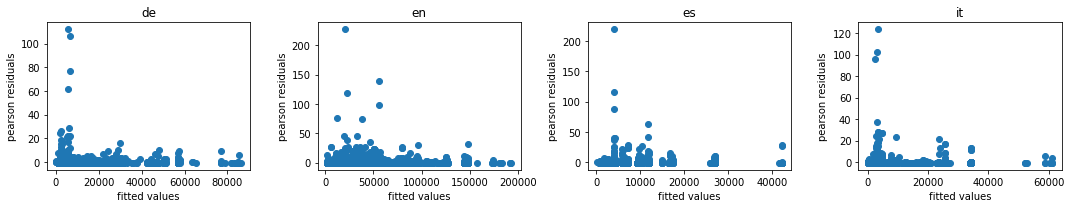

In [43]:
#fig.subplot
fig, axs = plt.subplots(ncols=4, figsize=(15, 3))
plot_pearson_residuals(df_filtered[df_filtered.code == 'de'], results_fit_separate_region['de'], title='de', ax=axs[0])
plot_pearson_residuals(df_filtered[df_filtered.code == 'en'], results_fit_separate_region['en'], title='en', ax=axs[1])
plot_pearson_residuals(df_filtered[df_filtered.code == 'es'], results_fit_separate_region['es'], title='es', ax=axs[2])
plot_pearson_residuals(df_filtered[df_filtered.code == 'de'], results_fit_separate_region['it'], title='it', ax=axs[3])
fig.tight_layout()

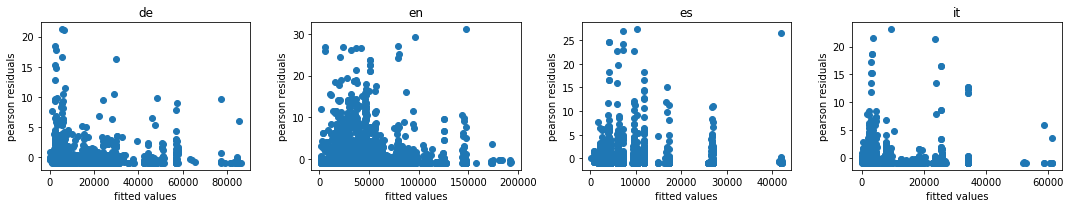

In [44]:
#fig.subplot
fig, axs = plt.subplots(ncols=4, figsize=(15, 3))
plot_pearson_residuals(df_filtered[df_filtered.code == 'de'], results_fit_separate_region['de'], exclude_n_outliers=10,
                       title='de', ax=axs[0])
plot_pearson_residuals(df_filtered[df_filtered.code == 'en'], results_fit_separate_region['en'], exclude_n_outliers=10,
                       title='en', ax=axs[1])
plot_pearson_residuals(df_filtered[df_filtered.code == 'es'], results_fit_separate_region['es'], exclude_n_outliers=10,
                       title='es', ax=axs[2])
plot_pearson_residuals(df_filtered[df_filtered.code == 'de'], results_fit_separate_region['it'], exclude_n_outliers=10,
                       title='it', ax=axs[3])
fig.tight_layout()

In [45]:
from plot_regression import compute_regression_outliers_from_residual

resid_outliers, outlier_filter = {}, {}
for code in ['de', 'it', 'es', 'en']:
    resid_outliers[code], outlier_filter[code] = compute_regression_outliers_from_residual(
        results_fit_separate_region[code])
all_outliers = pd.concat(resid_outliers.values())
all_filters = ~df_filtered.index.isin(all_outliers.index)

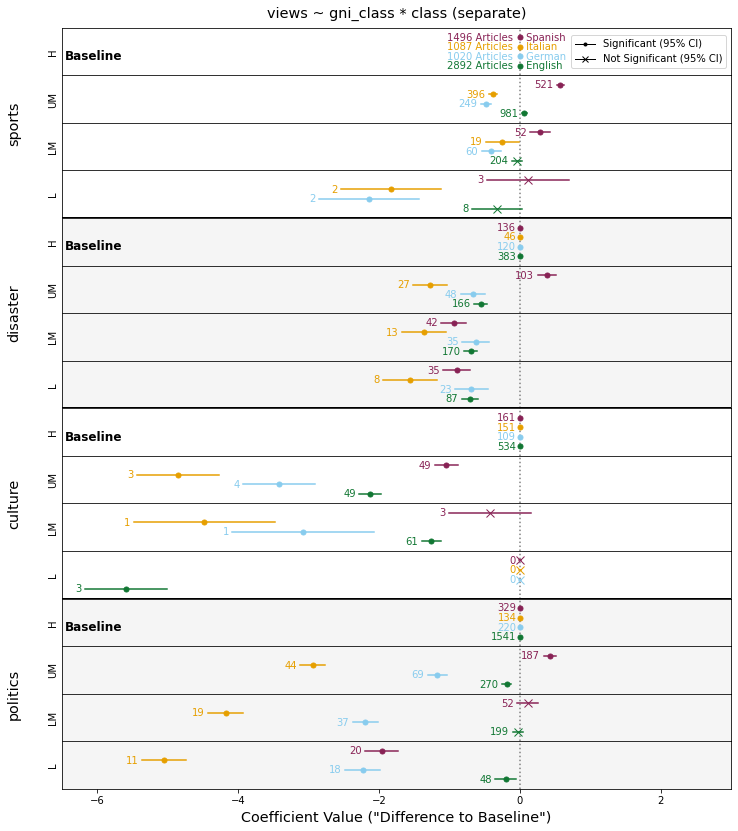

In [46]:
from regression import fit_regression_and_rename_coeffs_by_cat

results_fit_separate_region_filtered = fit_regression_and_rename_coeffs_by_cat(df_filtered.loc[all_filters, :],
                                                                               formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_class, Treatment(reference='H'))",
                                                                               type='nb')

fig_int_class_cat_nb_filtered = plot_regression_results_interactions_from_dict(df_filtered.loc[all_filters, :],
                                                                               results_fit_separate_region_filtered,
                                                                               ['cat:gni_class'],
                                                                               {'gni_class': 'H', 'in_code_lang': True,
                                                                                'gni_region': 'North America',
                                                                                'cat': 'sports', 'code': 'en'},
                                                                               label_sort={
                                                                                   'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                   'cat': ['sports', 'disaster',
                                                                                           'culture', 'politics'],
                                                                                   'gni_region': ['North America',
                                                                                                  'Europe & Central Asia',
                                                                                                  'Middle East & North Africa',
                                                                                                  'East Asia & Pacific',
                                                                                                  'South Asia',
                                                                                                  'Latin America & Caribbean',
                                                                                                  'Sub-Saharan Africa']},
                                                                               cat_dict={'en': 'English',
                                                                                         'it': 'Italian',
                                                                                         'es': 'Spanish',
                                                                                         'de': 'German'},
                                                                               title='views ~ gni_class * class (separate)',
                                                                               label_rename_dict={
                                                                                   'Middle East & North Africa': 'MENAf',
                                                                                   'Latin America & Caribbean': 'LatAmC',
                                                                                   'Europe & Central Asia': 'EuCAs',
                                                                                   'East Asia & Pacific': 'EAsP',
                                                                                   'North America': 'NAm',
                                                                                   'Sub-Saharan Africa': 'SSAf',
                                                                                   'South Asia': 'SAs'},
                                                                               figsize=(12, 14), x_limits=(-6.5, 3),
                                                                               include_counts=True)

In [47]:
df_filtered.views_baseline_cat.value_counts()>10^9

>10^7    True
>10^6    True
>10^8    True
>10^5    True
>10^9    True
>10^4    True
>10^3    True
>10^2    True
>=0      True
Name: views_baseline_cat, dtype: bool

In [48]:
results_fit_separate_class_controlcat['en'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                 7606
Model:                            GLM   Df Residuals:                     7582
Model Family:        NegativeBinomial   Df Model:                           23
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -87118.
Date:                Tue, 08 Mar 2022   Deviance:                       30038.
Time:                        08:39:27   Pearson chi2:                 1.18e+05
No. Iterations:                    12   Pseudo R-squ. (CS):             0.2693
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                     10.2799      0.029    353.298      0.000      10.223      10.337
cat[T.culture]                                                 0.2496      0.048      5.241      0.000       0.156       0.343
cat[T.disaster]                                                1.3356      0.055     24.481      0.000       1.229       1.443
cat[T.politics]                                                0.3646      0.033     11.190      0.000       0.301       0.428
gni_class[T.L]                                                 0.7875      0.360      2.187      0.029       0.082       1.493
gni_class[T.LM]                                                0.4910      0.074      6.655      0.000       0.346       0.636
gni_class[T.UM]                                                0.7264      0.039     18.618      0.000       0.650       0.803
views_baseline_cat, Treatment(reference='>10^8'))[T.>10^2]    -2.7591      1.003     -2.752      0.006      -4.724      -0.794
views_baseline_cat, Treatment(reference='>10^8'))[T.>10^3]    -0.9970      0.314     -3.179      0.001      -1.612      -0.382
views_baseline_cat, Treatment(reference='>10^8'))[T.>10^4]    -2.1721      0.124    -17.475      0.000      -2.416      -1.928
views_baseline_cat, Treatment(reference='>10^8'))[T.>10^5]    -1.2110      0.088    -13.743      0.000      -1.384      -1.038
views_baseline_cat, Treatment(reference='>10^8'))[T.>10^6]    -1.0130      0.050    -20.341      0.000      -1.111      -0.915
views_baseline_cat, Treatment(reference='>10^8'))[T.>10^7]    -0.4321      0.033    -13.286      0.000      -0.496      -0.368
views_baseline_cat, Treatment(reference='>10^8'))[T.>10^9]     0.4574      0.035     13.091      0.000       0.389       0.526
views_baseline_cat, Treatment(reference='>10^8'))[T.>=0]      -0.8525      0.709     -1.203      0.229      -2.242       0.536
cat[T.culture]:gni_class[T.L]                                 -5.0173      0.681     -7.367      0.000      -6.352      -3.682
cat[T.disaster]:gni_class[T.L]                                -0.2715      0.374     -0.725      0.468      -1.005       0.462
cat[T.politics]:gni_class[T.L]                                 0.0364      0.385      0.094      0.925      -0.719       0.792
cat[T.culture]:gni_class[T.LM]                                -1.3076      0.154     -8.500      0.000      -1.609      -1.006
cat[T.disaster]:gni_class[T.LM]                               -0.8349      0.117     -7.116      0.000      -1.065      -0.605
cat[T.politics]:gni_class[T.LM]                               -0.0899      0.105     -0.854      0.393      -0.296       0.117
cat[T.culture]:gni_class[T.UM]     

In [49]:
df_filtered.groupby(['code', 'views_baseline_cat']).count()

event_id  pagetitle  event_date  economic_region  \
code views_baseline_cat                                                     
de   >10^2                      8          8           8                8   
     >10^3                     62         62          62               62   
     >10^4                    177        177         177              177   
     >10^5                    418        418         418              418   
     >10^6                    888        888         888              888   
     >10^7                    293        293         293              293   
     >10^8                    175        175         175              175   
     >=0                        4          4           4                4   
en   >10^2                      1          1           1                1   
     >10^3                     11         11          11               11   
     >10^4                     72         72          72               72   
     >10^5                    193        193         193              193   
     >10^6                    683        683         683              683   
     >10^7                   3250       3250        3250             3250   
     >10^8                   1624       1624        1624             1624   
     >10^9                   1770       1770        1770             1770   
     >=0                        2          2           2                2   
es   >10^2                     17         17          17               17   
     >10^3                     97         97          97               97   
     >10^4                    225        225         225              225   
     >10^5                    664        664         664              664   
     >10^6                   1141       1141        1141             1141   
     >10^7                    537        537         537              537   
     >10^8                    512        512         512              512   
     >=0                        6          6           6                6   
it   >10^2                      7          7           7                7   
     >10^3                     36         36          36               36   
     >10^4                    176        176         176              176   
     >10^5                    737        737         737              737   
     >10^6                    598        598         598              598   
     >10^7                      7          7           7                7   
     >10^8                    408        408         408              408   
     >=0                        2          2           2                2   

                         country  continent   cat  categories  views_7_sum  \
code views_baseline_cat                                                      
de   >10^2                     8          8     8           8            8   
     >10^3                    62         62    62          62           62   
     >10^4                   177        177   177         177          177   
     >10^5                   418        418   418         418          418   
     >10^6                   888        888   888         888          888   
     >10^7                   293        293   293         293          293   
     >10^8                   175        175   175         175          175   
     >=0                       4          4     4           4            4   
en   >10^2                     1          1     1           1            1   
     >10^3                    11         11    11          11           11   
     >10^4                    72         72    72          72           72   
     >10^5                   193        193   193         193          193   
     >10^6                   683        683   683         683          683   
     >10^7                  3250       3250  3250        3250         3250   
     >10^8                  1624       1624  1624        1624         1624   
   

## Just try and fit a good model :-)

In [87]:
from steinkasserer.regression import fit_negative_binomial_regression_and_rename_coeffs
results_nb_raw = fit_negative_binomial_regression_and_rename_coeffs(df_filtered,
                                                                     formula="views_7_sum ~ C(code, Treatment(reference='en'))")
results_nb_raw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                14801
Model:                            GLM   Df Residuals:                    14797
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.6116e+05
Date:                Tue, 08 Mar 2022   Deviance:                       65437.
Time:                        10:31:28   Pearson chi2:                 3.34e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3990
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.6106      0.011    925.368      0.000      10.588      10.633
code[T.de]    -1.1705      0.025    -46.807      0.000      -1.220      -1.121
code[T.es]    -1.5558      0.021    -73.825      0.000      -1.597      -1.514
code[T.it]    -1.6978      0.025    -67.171      0.000      -1.747      -1.648
==============================================================================
"""

In [88]:
results_nb_base = fit_negative_binomial_regression_and_rename_coeffs(df_filtered,
                                                                     formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(code, Treatment(reference='en'))")
results_nb_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                14801
Model:                            GLM   Df Residuals:                    14785
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5898e+05
Date:                Tue, 08 Mar 2022   Deviance:                       61088.
Time:                        10:31:40   Pearson chi2:                 3.49e+05
No. Iterations:                     9   Pseudo R-squ. (CS):             0.5520
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     10.3195      0.016    660.032      0.000      10.289      10.350
cat[T.culture]                 0.3650      0.042      8.634      0.000       0.282       0.448
cat[T.disaster]                1.0446      0.039     27.119      0.000       0.969       1.120
cat[T.politics]                0.3277      0.027     12.130      0.000       0.275       0.381
code[T.de]                    -1.8091      0.031    -57.489      0.000      -1.871      -1.747
code[T.es]                    -1.6077      0.027    -59.696      0.000      -1.660      -1.555
code[T.it]                    -2.1338      0.030    -70.924      0.000      -2.193      -2.075
cat[T.culture]:code[T.de]      1.0563      0.106      9.934      0.000       0.848       1.265
cat[T.disaster]:code[T.de]     0.5820      0.082      7.134      0.000       0.422       0.742
cat[T.politics]:code[T.de]     1.5136      0.066     22.863      0.000       1.384       1.643
cat[T.culture]:code[T.es]     -0.0883      0.083     -1.060      0.289      -0.252       0.075
cat[T.disaster]:code[T.es]    -0.6142      0.072     -8.576      0.000      -0.755      -0.474
cat[T.politics]:code[T.es]     0.7086      0.054     13.138      0.000       0.603       0.814
cat[T.culture]:code[T.it]      1.7478      0.094     18.526      0.000       1.563       1.933
cat[T.disaster]:code[T.it]    -0.4740      0.113     -4.192      0.000      -0.696      -0.252
cat[T.politics]:code[T.it]     1.3521      0.079     17.173      0.000       1.198       1.506
==============================================================================================
"""

In [89]:
results_nb_class = fit_negative_binomial_regression_and_rename_coeffs(df_filtered,
                                                                formula="views_7_sum ~ (C(cat, Treatment(reference='sports')) + C(gni_class, Treatment(reference='H')) + in_code_lang + in_code_region) * C(code, Treatment(reference='en')) + np.log1p(views_baseline)")

results_nb_class.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                14801
Model:                            GLM   Df Residuals:                    14764
Model Family:        NegativeBinomial   Df Model:                           36
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5757e+05
Date:                Tue, 08 Mar 2022   Deviance:                       58258.
Time:                        10:32:02   Pearson chi2:                 2.53e+05
No. Iterations:                    28   Pseudo R-squ. (CS):             0.6300
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             6.7081      0.099     67.968      0.000       6.515       6.902
cat[T.culture]                        0.0970      0.043      2.257      0.024       0.013       0.181
cat[T.disaster]                       1.0563      0.040     26.122      0.000       0.977       1.136
cat[T.politics]                       0.3260      0.028     11.723      0.000       0.271       0.380
gni_class[T.L]                        0.8048      0.091      8.871      0.000       0.627       0.983
gni_class[T.LM]                       0.2243      0.047      4.813      0.000       0.133       0.316
gni_class[T.UM]                       0.5557      0.032     17.450      0.000       0.493       0.618
in_code_lang[T.True]                 -0.0531      0.039     -1.368      0.171      -0.129       0.023
in_code_region[T.True]                0.1440      0.047      3.087      0.002       0.053       0.235
code[T.de]                           -0.8820      0.041    -21.271      0.000      -0.963      -0.801
code[T.es]                           -0.8462      0.038    -22.483      0.000      -0.920      -0.772
code[T.it]                           -1.0200      0.045    -22.742      0.000      -1.108      -0.932
cat[T.culture]:code[T.de]             1.0610      0.108      9.843      0.000       0.850       1.272
cat[T.disaster]:code[T.de]            0.8143      0.085      9.568      0.000       0.647       0.981
cat[T.politics]:code[T.de]            1.5277      0.068     22.523      0.000       1.395       1.661
cat[T.culture]:code[T.es]             0.0269      0.085      0.315      0.753      -0.140       0.194
cat[T.disaster]:code[T.es]           -0.6411      0.075     -8.521      0.000      -0.789      -0.494
cat[T.politics]:code[T.es]            0.6014      0.056     10.740      0.000       0.492       0.711
cat[T.culture]:code[T.it]             1.7584      0.096     18.341      0.000       1.571       1.946
cat[T.disaster]:code[T.it]           -0.2309      0.117     -1.974      0.048      -0.460      -0.002
cat[T.politics]:code[T.it]            1.1917      0.081     14.703      0.000       1.033       1.351
gni_class[T.L]:code[T.de]            -0.8553      0.183     -4.674      0.000      -1.214      -0.497
gni_class[T.LM]:code[T.de]           -0.6961      0.105     -6.656      0.000      -0.901      -0.491
gni_class[T.UM]:code[T.de]           -0.1082      0.068     -1.600      0.109      -0.241       0.024
gni_class[T.L]:code[T.es]            -0.5614      0.164     -3.426      0.001      -0.883      -0.240
gni_class[T.LM]:code[T.es]            0.1695      0.099      1.710      0.087      -0.025       0.364
gni_class[T.UM]:code[T.es]            0.0840      0.056      1.489      0.137      -0.027       0.195
gni_class[T.L]:code[T.i

In [91]:
results_nb_region = fit_negative_binomial_regression_and_rename_coeffs(df_filtered,
                                                                      formula="views_7_sum ~ (C(cat, Treatment(reference='sports')) + C(gni_region, Treatment(reference='North America')) + in_code_lang + in_code_region) * C(code, Treatment(reference='en')) + np.log1p(views_baseline)")

results_nb_region.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                14801
Model:                            GLM   Df Residuals:                    14752
Model Family:        NegativeBinomial   Df Model:                           48
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5756e+05
Date:                Tue, 08 Mar 2022   Deviance:                       58236.
Time:                        10:32:20   Pearson chi2:                 3.13e+05
No. Iterations:                    27   Pseudo R-squ. (CS):             0.6305
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                               6.4499      0.143     45.196      0.000       6.170       6.730
cat[T.culture]                                          0.0994      0.043      2.307      0.021       0.015       0.184
cat[T.disaster]                                         1.0570      0.041     26.098      0.000       0.978       1.136
cat[T.politics]                                         0.3485      0.028     12.502      0.000       0.294       0.403
gni_region[T.East Asia & Pacific]                       0.3344      0.086      3.896      0.000       0.166       0.503
gni_region[T.Europe & Central Asia]                     0.0698      0.089      0.781      0.435      -0.105       0.245
gni_region[T.Latin America & Caribbean]                 0.5424      0.095      5.688      0.000       0.356       0.729
gni_region[T.Middle East & North Africa]                0.7646      0.110      6.954      0.000       0.549       0.980
gni_region[T.South Asia]                                0.2980      0.102      2.914      0.004       0.098       0.498
gni_region[T.Sub-Saharan Africa]                        0.9931      0.111      8.952      0.000       0.776       1.211
in_code_lang[T.True]                                   -0.2452      0.048     -5.060      0.000      -0.340      -0.150
in_code_region[T.True]                                  0.3029      0.079      3.844      0.000       0.148       0.457
code[T.de]                                             -1.1969      0.110    -10.853      0.000      -1.413      -0.981
code[T.es]                                             -0.7588      0.108     -7.027      0.000      -0.971      -0.547
code[T.it]                                             -0.6619      0.120     -5.504      0.000      -0.898      -0.426
cat[T.culture]:code[T.de]                               1.2548      0.108     11.576      0.000       1.042       1.467
cat[T.disaster]:code[T.de]                              0.7503      0.085      8.851      0.000       0.584       0.916
cat[T.politics]:code[T.de]                              1.5459      0.068     22.738      0.000       1.413       1.679
cat[T.culture]:code[T.es]                               0.0441      0.086      0.510      0.610      -0.125       0.214
cat[T.disaster]:code[T.es]                             -0.6255      0.075     -8.293      0.000      -0.773      -0.478
cat[T.politics]:code[T.es]                              0.6035      0.057     10.667      0.000       0.493       0.714
cat[T.culture]:code[T.it]                               1.6371      0.098     16.630      0.000       1.444       1.830
cat[T.disaster]:code[T.it]                             -0.4894      0.117     -4.17